In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from scipy.stats import chi2_contingency

from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso,Ridge

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,roc_curve

import warnings

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Removing Unwanted Columns

In [4]:
df.drop('Id',axis=1,inplace=True)

In [6]:
missing_values = df.isna().sum(axis=0)/df.shape[0]
missing_values = missing_values.loc[missing_values>0]

<AxesSubplot:title={'center':'Missing Columns'}, ylabel=' % missing '>

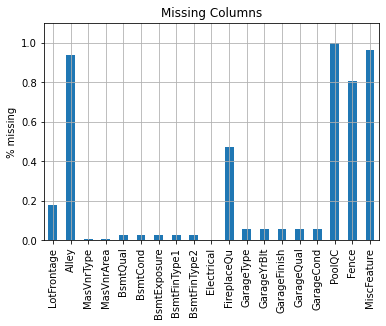

In [7]:
missing_values.sort_values(ascending=True)
missing_values.plot(kind='bar',title='Missing Columns',ylabel=' % missing ',ylim=(0,1.1),grid=True)

### Columns with over 10% missing values

In [8]:
drop_columns = missing_values.loc[missing_values > 0.1].index
drop_columns

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [9]:
df['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [10]:
fill_na_columns = drop_columns.delete([0,-1])
fill_na_columns

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence'], dtype='object')

In [11]:
for feature in fill_na_columns:
    df.loc[:,feature].fillna(value='None',inplace=True)

In [12]:
df.loc[:,'LotFrontage'].fillna(value=0 , inplace=True)

In [13]:
df.drop(columns='MiscFeature',inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### split ordinal,numeric,nominal

In [15]:
numeric_cols = list(df.select_dtypes(exclude='object'))
ordinal_cols = ['SaleCondition','SaleType','PavedDrive','GarageCond','GarageQual','KitchenQual','BsmtQual','BsmtCond','ExterQual','ExterCond','Condition1','Condition2']
nominal_cols = list(set(df.columns) - set(ordinal_cols) - set(numeric_cols))
numeric_cols.remove('SalePrice')

### Pipeline

In [16]:
ordinal_pipeline = Pipeline([
    ('imputer_o' , SimpleImputer(strategy='most_frequent')),
    ('encoder_o', OneHotEncoder(sparse=True,handle_unknown='ignore'))
])

nominal_pipeline = Pipeline([
    ('imputer_n' , SimpleImputer(strategy='most_frequent')),
    ('encoder_n', OneHotEncoder(sparse=True,handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer_nu' , SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])

In [18]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor' ,nominal_pipeline,nominal_cols),
    ('ordinal_preprocessor', ordinal_pipeline,ordinal_cols),
    ('numerical_preprocessor', numerical_pipeline,numeric_cols)
])

### Lasso

In [19]:
lasso_model = Pipeline([
    ('preprocessor',preprocessing_pipeline),
    ('lasso_regression',Lasso(tol=0.001,max_iter=1e7,precompute=True,random_state=42))
])

### Ridge

In [20]:
ridge_model = Pipeline([
    ('preprocessor',preprocessing_pipeline),
    ('ridge_regression',Ridge(max_iter=1e7,random_state=42))
])

### Linear

In [21]:
linear_model = Pipeline([
    ('preprocessor',preprocessing_pipeline),
    ('linear_regression',LinearRegression(n_jobs=-1))
])

In [22]:
X = df[nominal_cols+ordinal_cols+numeric_cols]
y = df['SalePrice']

### Split

In [23]:
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.3 , random_state=42)

In [24]:
y_train.head()

135     174000
1452    145000
762     215200
932     320000
435     212000
Name: SalePrice, dtype: int64

### Fitting

In [25]:
cross_val = KFold(n_splits=10)
scores_ridge = cross_val_score(ridge_model,X=X_train,y=y_train,cv=cross_val)
scores_ridge.mean()
print("Ridge Regression Fitted With Accuracy : {0:.2f} ".format(scores_ridge.mean()))

Ridge Regression Fitted With Accuracy : 0.79 


In [30]:
cross_val = KFold(n_splits=10)
scores_lasso = cross_val_score(lasso_model,X=X_train,y=y_train,cv=cross_val)
scores_lasso.mean()
print("Lasso Regression Fitted With Accuracy : {0:.2f} ".format(scores_lasso.mean()))

Lasso Regression Fitted With Accuracy : 0.73 


In [29]:
cross_val = KFold(n_splits=10)
scores_linear = cross_val_score(linear_model,X=X_train,y=y_train,cv=cross_val)
scores_linear.mean()
print("Linear Regression Fitted With Accuracy : {0:.2f} ".format(scores_linear.mean()))

Linear Regression Fitted With Accuracy : 0.59 


In [31]:
ridge_model.fit(X_train,y_train)
ridge_model.score(X_test,y_test)

0.8813899842702637

In [32]:
linear_model.fit(X_train,y_train)
linear_model.score(X_test,y_test)

0.35246996750271054

In [33]:
lasso_model.fit(X_train,y_train)
lasso_model.score(X_test,y_test)

0.6667669921231595

### Best Ridge

It Is Obvious that given the HUGE number of features, Linear Regression was severely prone to overfitting. This overfitting was somewhat reduced but not completely fixed by lasso regression which applied the l1 penalty on all our features.  
Finally, Ridge Regression completely overcame the problem of overfitting by applying the l2 penalty on our feature set and emerged as the best performing model

In [36]:
df_test.drop('Id',axis=1,inplace=True)

In [37]:
y_predictions = ridge_model.predict(df_test)